## Импорт библиотек
Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Загрузим датасеты.

### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [2]:
df_cloc = pd.read_csv('./datasets/01_CLocation_July.csv')
print(df_cloc.shape)
df_cloc.head(3)

(10240, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


In [3]:
df_cloc.describe()

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
count,10240.000000,10240.000000,10240.000000,10240.000000,10240.000000
mean,83354.220801,849.844043,437.173340,746.294727,46.906055
std,26541.011327,1259.753844,967.704186,1255.423503,72.207831
min,32909.000000,1.000000,0.000000,0.000000,0.000000
25%,61420.750000,32.000000,8.000000,27.000000,1.000000
50%,84247.500000,162.000000,52.000000,132.000000,7.000000
75%,105738.250000,1268.250000,497.000000,1055.000000,70.000000
max,139343.000000,8887.000000,14870.000000,15741.000000,441.000000


In [4]:
df_loc = pd.read_csv('./datasets/01_Location_July.csv')
print(df_loc.shape)
df_loc.head(3)

(146, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [5]:
df_loc.describe()

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
count,146.000000,146.000000,146.000000,146.000000,146.000000
mean,87.876712,59646.335616,30699.972603,52397.143836,3291.547945
std,70.122149,29518.906950,29366.464478,34005.814909,1813.331668
min,1.000000,6110.000000,1211.000000,3370.000000,347.000000
25%,37.250000,40128.750000,12508.750000,30895.000000,2024.500000
50%,73.500000,56641.000000,23154.000000,45121.500000,3205.500000
75%,109.750000,72915.750000,38872.500000,64568.000000,4157.000000
max,276.000000,170772.000000,179375.000000,213125.000000,10472.000000


### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [6]:
df_chome_work = pd.read_csv('./datasets/04_CMatrix_Home_Work_July.csv')
df_chome_work.describe()

,home_zid,work_zid,customers_cnt
count,724443.000000,724443.000000,724443.000000
mean,102367.038804,104025.091897,14.168672
std,21472.454803,20157.290571,120.538750
min,-2.000000,-2.000000,1.000000
25%,94413.000000,99808.000000,2.000000
50%,104591.000000,108662.000000,3.000000
75%,116118.000000,113839.000000,3.000000
max,139343.000000,139343.000000,6178.000000


<AxesSubplot:>

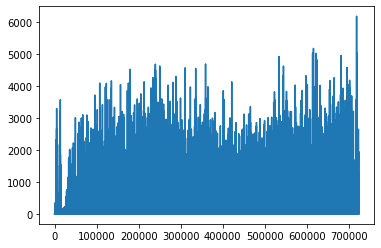

In [7]:
df_chome_work['customers_cnt'].plot()

In [8]:
df_home_work = pd.read_csv('./datasets/04_Matrix_Home_Work_July.csv')
df_home_work.describe()

,home_zid,work_zid,customers_cnt
count,20608.000000,20608.000000,20608.000000
mean,85.175320,83.041828,498.779988
std,68.865673,66.775621,3723.609495
min,-2.000000,-2.000000,0.000000
25%,35.000000,35.000000,9.000000
50%,72.000000,70.000000,31.000000
75%,108.000000,106.000000,106.000000
max,276.000000,276.000000,113207.000000


<AxesSubplot:>

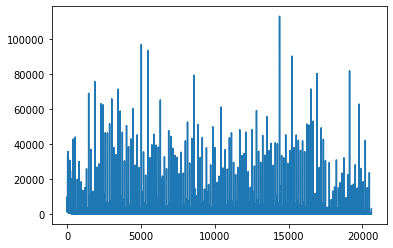

In [9]:
df_home_work['customers_cnt'].plot()

In [10]:
print('Количество значений с zid = -2:', df_home_work.loc[df_home_work['home_zid'] == -2].shape[0])

Количество значений с zid = -2: 146


In [11]:
print('Количество значений с zid = -2:', df_home_work.query('home_zid <= 0 or work_zid <= 0').shape[0])

Количество значений с zid = -2: 584


In [12]:
print(
    'Процент значений в Matrix_Home_Work_July с zid<=0:',
    round(df_home_work.loc[(df_home_work['home_zid'] <= 0) | (df_home_work['work_zid'] <= 0)].shape[0]/df_home_work.shape[0]*100, 2),
    '%'
)


Процент значений в Matrix_Home_Work_July с zid<=0: 2.83 %


In [13]:
print(
    'Процент значений в CMatrix_Home_Work_July с zid<=0:',
    round(df_chome_work.loc[(df_chome_work['home_zid'] <= 0) | (df_chome_work['work_zid'] <= 0)].shape[0]/df_chome_work.shape[0]*100, 2),
    '%'
)


Процент значений в CMatrix_Home_Work_July с zid<=0: 4.48 %


## Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [14]:
#df_sector_rel = pd.read_excel('./datasets/Справочник_соотношения_секторов_500х500м_и_адм_районов_МСК.xlsx')
#df_sector_rel.to_csv('./datasets/relations_between_500x500_and_MSC.csv', index=False)
df_sector_rel = pd.read_csv('./datasets/relations_between_500x500_and_MSC.csv')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [15]:
df_sector_rel.describe()

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid
count,13232.000000,1.323200e+04,13232.000000
mean,86399.263755,1.907860e+00,145.154776
std,26044.221345,8.655121e-01,88.766849
min,32909.000000,1.000000e-08,1.000000
25%,64572.750000,1.382770e+00,60.000000
50%,89067.000000,2.500603e+00,187.000000
75%,108079.250000,2.500670e+00,228.000000
max,139343.000000,2.500685e+00,276.000000


In [16]:
df_sector_rel['sub_ter'].value_counts()

Новая Москва     6734
Старая Москва    6498
Name: sub_ter, dtype: int64

In [17]:
new_zid_list = df_sector_rel.query('sub_ter == "Новая Москва"')['cell_zid'].to_list()

In [18]:
df_cloc[df_cloc['zid'].isin(new_zid_list)]

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0
3,33262,13,2,11,0
4,33263,10,0,3,0
...,...,...,...,...,...
6716,97395,586,214,481,30
6723,97403,2864,679,1507,201
6724,97404,1235,277,622,60
6725,97405,839,655,921,44


In [19]:
df_cloc[~df_cloc['zid'].isin(new_zid_list)]

,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
4315,75683,508,123,326,18
4316,75684,316,63,168,20
4388,76301,1697,255,899,105
4389,76302,1979,260,925,147
4462,76919,1424,296,776,77
...,...,...,...,...,...
10235,138913,77,455,495,1
10236,138914,165,796,884,8
10237,138915,587,1341,1661,19
10238,138916,1206,1669,2177,47


In [20]:
df_sector_rel.describe()

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid
count,13232.000000,1.323200e+04,13232.000000
mean,86399.263755,1.907860e+00,145.154776
std,26044.221345,8.655121e-01,88.766849
min,32909.000000,1.000000e-08,1.000000
25%,64572.750000,1.382770e+00,60.000000
50%,89067.000000,2.500603e+00,187.000000
75%,108079.250000,2.500670e+00,228.000000
max,139343.000000,2.500685e+00,276.000000


## Загрузим геоданные

In [21]:
shp_admzones = gpd.read_file('./datasets/admzones2021/admzones2021.shp')
shp_fishnet = gpd.read_file('./datasets/fishnet2021/fishnet2021.shp')

In [22]:
shp_admzones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adm_zid     206 non-null    int64   
 1   adm_name    206 non-null    object  
 2   okrug_name  146 non-null    object  
 3   sub_ter     206 non-null    object  
 4   okrug_id    146 non-null    float64 
 5   area        206 non-null    float64 
 6   geometry    206 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 11.4+ KB


In [23]:
shp_fishnet.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 189892 entries, 0 to 189891
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   cell_zid  189892 non-null  int64   
 1   geometry  189892 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 2.9 MB


In [24]:
shp_admzones.head()

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((38.30978 54.86069, 38.30978 54.86069..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((37.79389 55.62307, 37.79601 55.62424..."
2,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((37.75633 55.75959, 37.76380 55.76104..."
3,533,Мытищи,None,Московская область,NaN,4.312459e+08,"POLYGON ((37.73215 55.87984, 37.73064 55.88059..."
4,66,Тверской,Центральный административный округ,Старая Москва,569.0,7.322588e+06,"POLYGON ((37.61262 55.78248, 37.61457 55.78181..."


In [25]:
shp_fishnet.head()

,cell_zid,geometry
0,0,"POLYGON ((38.64721 54.25524, 38.64733 54.25973..."
1,1,"POLYGON ((38.65488 54.25517, 38.65500 54.25966..."
2,2,"POLYGON ((38.66255 54.25510, 38.66268 54.25959..."
3,3,"POLYGON ((38.67022 54.25502, 38.67035 54.25951..."
4,4,"POLYGON ((38.67789 54.25495, 38.67802 54.25944..."


In [26]:
#shp_fishnet.plot(figsize=(17,17))
#shp_admzones.plot(figsize=(17,17))
#plt.show()

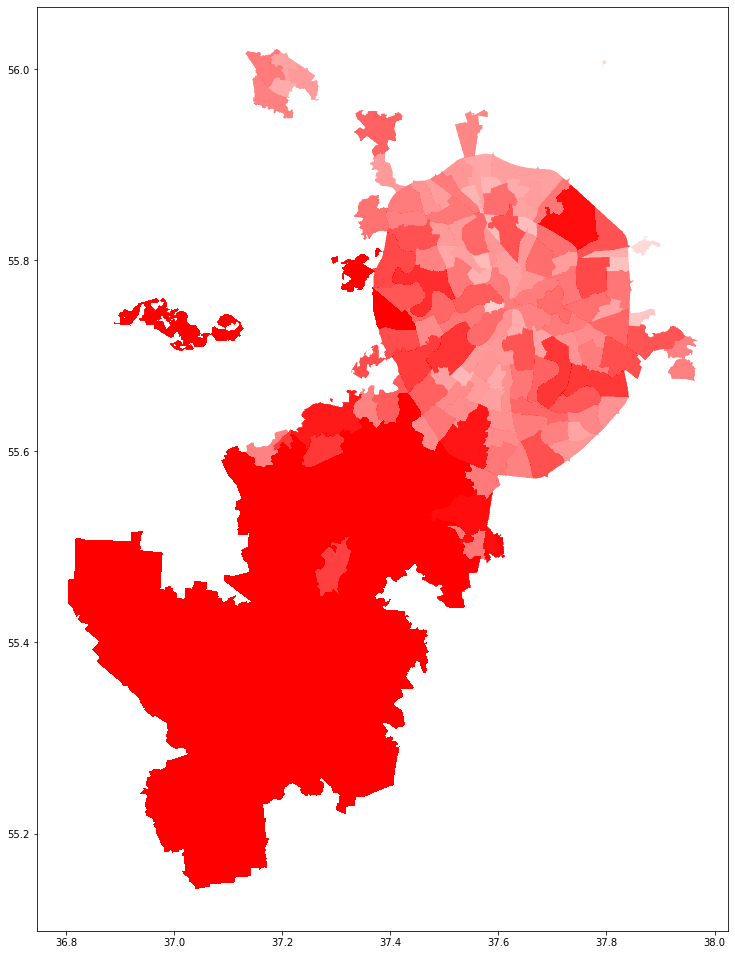

In [27]:
#ax = shp_admzones.plot(figsize=(17,17), alpha=0.5)

pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
).plot(figsize=(17,17), color='red', alpha=0.01)

plt.show()

In [28]:
#df_sector_rel = pd.read_excel('./datasets/Справочник_соотношения_секторов_500х500м_и_адм_районов_МСК.xlsx')
#df_sector_rel.to_csv('./datasets/relations_between_500x500_and_MSC.csv', index=False)
df_sector_rel = pd.read_csv('./datasets/relations_between_500x500_and_MSC.csv')

In [29]:
pd.read_excel('./data_mos_ru/data-4113-2021-10-11.xlsx').to_csv('./data_mos_ru/culture.csv', index=False)

C:\Users\femt0\miniforge3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [30]:
df_culture = pd.read_csv('./data_mos_ru/culture.csv').drop(['ObjectName', 'geoarea', 'Link'], axis=1)

In [31]:
df_culture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               516 non-null    int64 
 1   ObjectNameOnDoc  516 non-null    object
 2   global_id        516 non-null    int64 
 3   geodata_center   516 non-null    object
dtypes: int64(2), object(2)
memory usage: 16.2+ KB


In [32]:
import json
def coords(row):
    data = row['geodata_center']
    coord = json.loads(data)['coordinates']
    type_ = json.loads(data)['type']
    return coord, type_

In [33]:
df_culture

,ID,ObjectNameOnDoc,global_id,geodata_center
0,7537,Охранная (объединенная охранная) зона № 246,19657446,"{""coordinates"":[37.6829129971731,55.7449717020..."
1,7538,Охранная (объединенная охранная) зона,19657447,"{""coordinates"":[37.691525940131,55.73239338502..."
2,7539,Охранная (объединенная охранная) зона,19657448,"{""coordinates"":[37.6783533222778,55.7328870382..."
3,7540,Охранная (объединенная охранная) зона,19657449,"{""coordinates"":[37.5631385343507,55.7203998495..."
4,7541,Охранная (объединенная охранная) зона,19657450,"{""coordinates"":[37.4734141045037,55.7668006517..."
...,...,...,...,...
511,15685,Охранная зона объекта культурного наследия фед...,19657957,"{""coordinates"":[37.5674474887655,55.7332135163..."
512,16324,Зона регулирования застройки и хозяйственной д...,19657958,"{""coordinates"":[37.6286765715031,55.7654513933..."
513,16338,охранная зона объекта культурного наследия фед...,19657959,"{""coordinates"":[37.785402333162,55.78127890215..."
514,16641,"Охранная зона объекта культурного значения ""Це...",19657960,"{""coordinates"":[37.8129044286215,55.7584223166..."


In [34]:
df_culture['geodata_center'][0]

'{"coordinates":[37.6829129971731,55.744971702052],"type":"Point"}'

In [35]:
import json

In [36]:
json.loads(df_culture['geodata_center'][0])['type']

'Point'

In [37]:
df_culture[['coordinates', 'type']] = df_culture.apply(coords, axis=1, result_type='expand')

In [38]:
df_culture.head(2)

,ID,ObjectNameOnDoc,global_id,geodata_center,coordinates,type
0,7537,Охранная (объединенная охранная) зона № 246,19657446,"{""coordinates"":[37.6829129971731,55.7449717020...","[37.6829129971731, 55.744971702052]",Point
1,7538,Охранная (объединенная охранная) зона,19657447,"{""coordinates"":[37.691525940131,55.73239338502...","[37.691525940131, 55.7323933850285]",Point


## Загрузим клиники

In [39]:
pd.read_excel('./data_mos_ru/child_clinic.xlsx').to_csv('./data_mos_ru/child_clinic.csv', index=False)
pd.read_excel('./data_mos_ru/adult_clinic.xlsx').to_csv('./data_mos_ru/adult_clinic.csv', index=False)

C:\Users\femt0\miniforge3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [40]:
df_adult = pd.read_csv('./data_mos_ru/adult_clinic.csv')
df_child = pd.read_csv('./data_mos_ru/child_clinic.csv')

print('Процент потерь координат по взрослым клинникам:', 
      df_adult[df_adult['geodata_center'].isna()].shape[0]/df_adult.shape[0] * 100)

print('Процент потерь координат по детским клинникам:', 
      df_child[df_child['geodata_center'].isna()].shape[0]/df_child.shape[0] * 100)

Процент потерь координат по взрослым клинникам: 36.594202898550726
Процент потерь координат по детским клинникам: 72.11538461538461


In [41]:
import json
def coords(row):
    data = row['geodata_center']
    lat = json.loads(data)['coordinates'][0]
    long = json.loads(data)['coordinates'][1]
    return long, lat

In [42]:
json.loads(df_adult.geodata_center[0])['coordinates'][0]

37.653086720526

In [43]:
coords(df_adult.iloc[0])

(55.724858139317, 37.653086720526)

In [44]:
df_adult.dropna(subset=['geodata_center'], inplace=True)
df_child.dropna(subset=['geodata_center'], inplace=True)

print()

In [45]:
df_adult[['longitude', 'latitude']] = df_adult.apply(coords, axis=1, result_type='expand')

In [46]:
df_child[['longitude', 'latitude']] = df_child.apply(coords, axis=1, result_type='expand')

In [61]:
gdf_adult = gpd.GeoDataFrame(
    df_adult, geometry=gpd.points_from_xy(df_adult.latitude, df_adult.longitude))

In [62]:
gdf_child = gpd.GeoDataFrame(
    df_child, geometry=gpd.points_from_xy(df_child.latitude, df_child.longitude))

In [65]:
gdf_adult.crs = 'epsg:4326'
gdf_child.crs = 'epsg:4326'

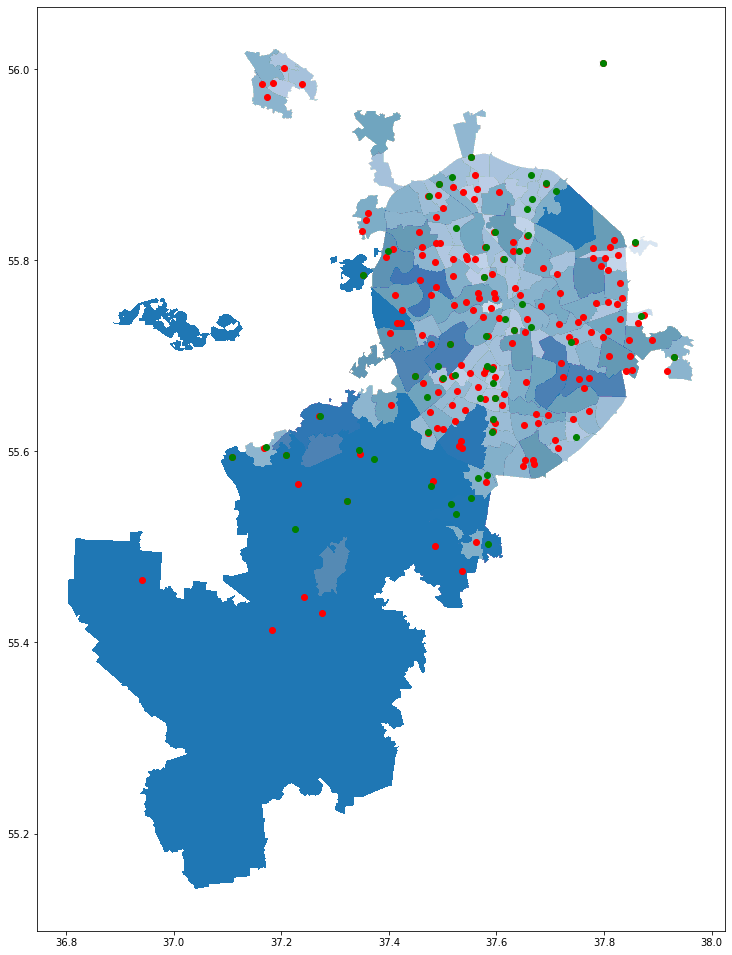

In [66]:
#ax = shp_admzones.cx[36.5:38.5, 55:56.5].plot(figsize=(17,17), alpha=0.5)
ax = pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
).plot(figsize=(17,17), alpha=0.01)

gdf_adult.plot(color='red', ax=ax)
gdf_child.plot(color='green', ax=ax)

plt.show()

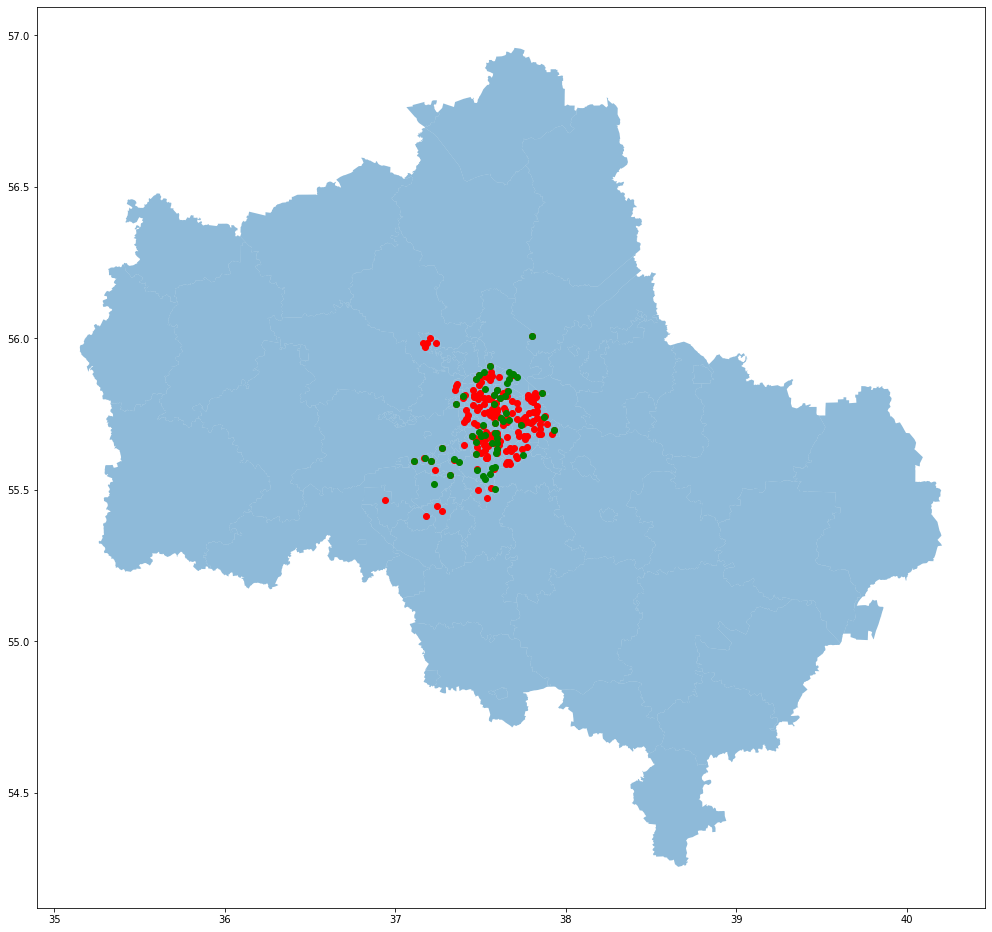

In [83]:
#ax = shp_admzones.cx[36.5:38.5, 55:56.5].plot(figsize=(17,17), alpha=0.5)
ax = shp_admzones.plot(figsize=(17,17), alpha=0.5)

gdf_adult.plot(color='red', ax=ax)
gdf_child.plot(color='green', ax=ax)

plt.show()

In [86]:
shp_fishnet

,cell_zid,geometry
0,0,"POLYGON ((38.64721 54.25524, 38.64733 54.25973..."
1,1,"POLYGON ((38.65488 54.25517, 38.65500 54.25966..."
2,2,"POLYGON ((38.66255 54.25510, 38.66268 54.25959..."
3,3,"POLYGON ((38.67022 54.25502, 38.67035 54.25951..."
4,4,"POLYGON ((38.67789 54.25495, 38.67802 54.25944..."
...,...,...
189887,190237,"POLYGON ((37.69324 56.95549, 37.69326 56.95998..."
189888,190238,"POLYGON ((37.70146 56.95548, 37.70148 56.95997..."
189889,190239,"POLYGON ((37.70968 56.95547, 37.70970 56.95996..."
189890,190240,"POLYGON ((37.71790 56.95545, 37.71792 56.95994..."


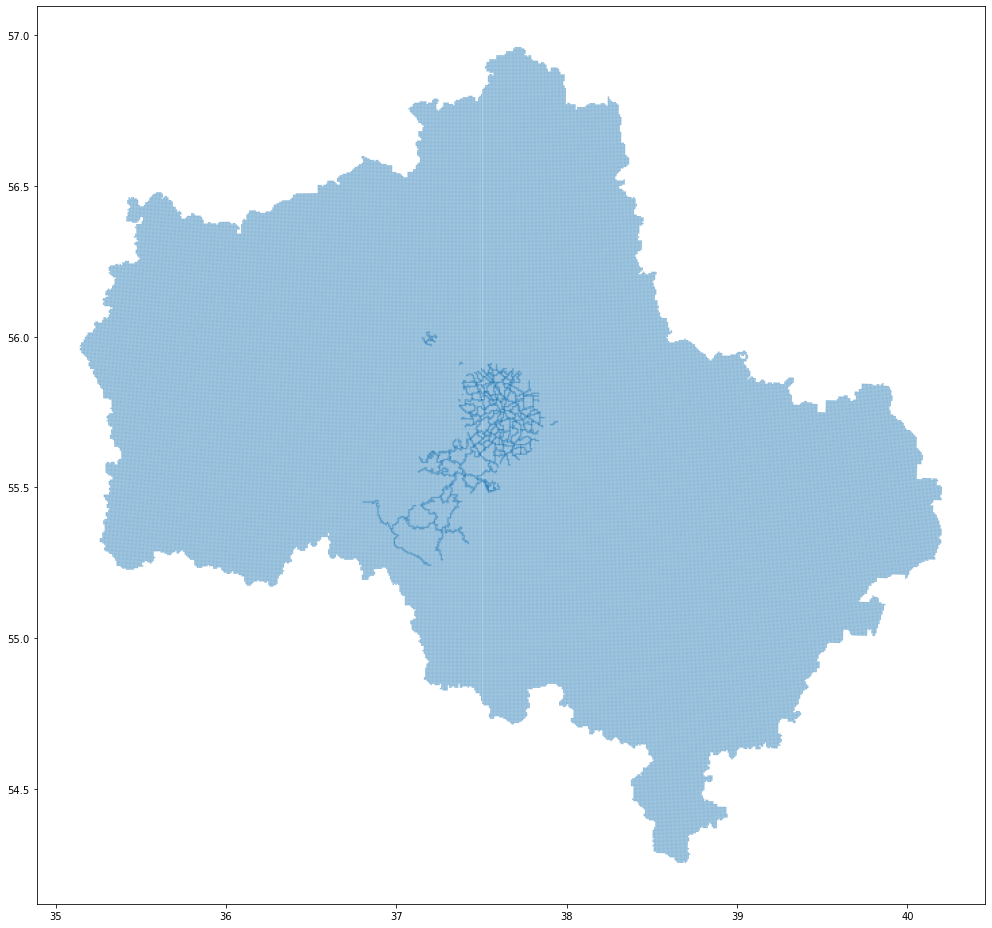

In [99]:
ax = pd.merge(
    shp_fishnet,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="left",
    on='cell_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
).plot(figsize=(17,17), alpha=0.5)

In [81]:
df_sector_rel

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва
3,33262,1.868032,216,Роговское,Троицкий административный округ,Новая Москва
4,33263,2.500630,216,Роговское,Троицкий административный округ,Новая Москва
...,...,...,...,...,...,...
13227,138914,0.585913,1,Силино,Зеленоградский административный округ,Старая Москва
13228,138915,2.342729,6,Матушкино,Зеленоградский административный округ,Старая Москва
13229,138915,0.157932,1,Силино,Зеленоградский административный округ,Старая Москва
13230,138916,2.315494,6,Матушкино,Зеленоградский административный округ,Старая Москва


In [100]:
pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="right",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry,cell_zid
0,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((36.98648 55.31557, 36.98760 55.31342...",32909
1,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((36.98648 55.31557, 36.98760 55.31342...",32910
2,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((36.98648 55.31557, 36.98760 55.31342...",33261
3,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((36.98648 55.31557, 36.98760 55.31342...",33262
4,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((36.98648 55.31557, 36.98760 55.31342...",33263
...,...,...,...,...,...,...,...,...
13227,1,Силино,Зеленоградский административный округ,Старая Москва,563.0,9.436377e+06,"POLYGON ((37.19561 56.01868, 37.19215 56.01508...",138914
13228,6,Матушкино,Зеленоградский административный округ,Старая Москва,563.0,5.029623e+06,"POLYGON ((37.20075 56.01661, 37.20333 56.01555...",138915
13229,1,Силино,Зеленоградский административный округ,Старая Москва,563.0,9.436377e+06,"POLYGON ((37.19561 56.01868, 37.19215 56.01508...",138915
13230,6,Матушкино,Зеленоградский административный округ,Старая Москва,563.0,5.029623e+06,"POLYGON ((37.20075 56.01661, 37.20333 56.01555...",138916


In [76]:
shp_admzones

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((38.30978 54.86069, 38.30978 54.86069..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((37.79389 55.62307, 37.79601 55.62424..."
2,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((37.75633 55.75959, 37.76380 55.76104..."
3,533,Мытищи,None,Московская область,NaN,4.312459e+08,"POLYGON ((37.73215 55.87984, 37.73064 55.88059..."
4,66,Тверской,Центральный административный округ,Старая Москва,569.0,7.322588e+06,"POLYGON ((37.61262 55.78248, 37.61457 55.78181..."
...,...,...,...,...,...,...,...
201,515,Звездный городок,None,Московская область,NaN,3.179077e+06,"POLYGON ((38.11824 55.88811, 38.11824 55.88811..."
202,535,Ногинск (Богородский),None,Московская область,NaN,8.101810e+08,"POLYGON ((38.11977 55.75602, 38.12061 55.75644..."
203,560,Электросталь,None,Московская область,NaN,1.353985e+08,"POLYGON ((38.46365 55.82665, 38.46372 55.82660..."
204,526,Лосино-Петровский,None,Московская область,NaN,9.128970e+07,"POLYGON ((38.23686 55.90859, 38.23754 55.90836..."
